In [3]:
import os
import time

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.io import read_image

from my_utils import data, models
from my_utils.utils import check_accuracy
from my_utils.vis import grid_vis, Vis_cam

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

In [4]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:{0}" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.10.2
Using cpu now!


In [3]:
batch_size = 512
fig_resize = 64
# mean, std = torch.tensor(0.2036), torch.tensor(0.4027)  # polygons_unfilled_32_2
mean, std = torch.tensor(0.1094), torch.tensor(0.3660)  # polygons_unfilled_64_3
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((fig_resize, fig_resize)),
    transforms.Normalize(mean, std)
])
loader_kwargs = {
    'batch_size': batch_size,   # default:1
    'shuffle': True,            # default:False
    'num_workers': 4,           # default:0
    'pin_memory': True,         # default:False
    'drop_last': True,          # default:False
    'prefetch_factor': 4,       # default:2
    'persistent_workers': False # default:False
}

In [4]:
# 制作二进制数据集
Dataset_DIR = '/home/wangyh/01-Projects/03-my/Datasets/polygons_unfilled_64_3_vertex_0.05'

test_data = data.MyDataset(os.path.join(Dataset_DIR, 'test'), transform=T)
test_loader = DataLoader(test_data, **loader_kwargs)

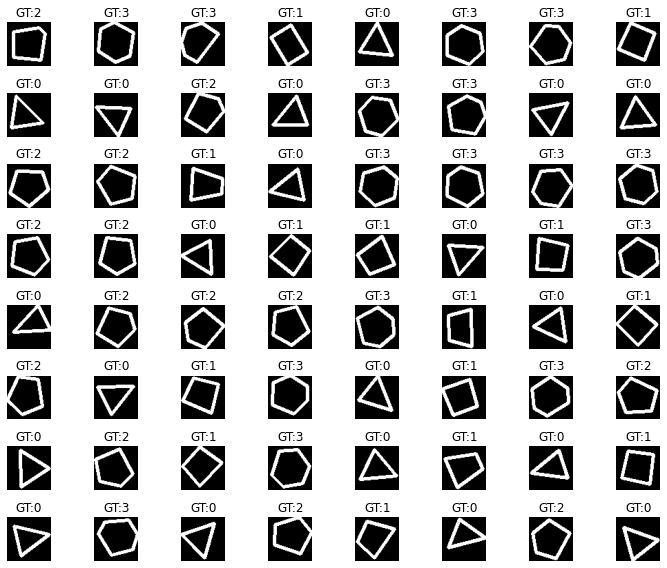

In [6]:
grid_vis(test_loader, 8)

In [5]:
# model = models.my_ConvNeXt(kernel_size=5, depths=(1, 1, 1), dims=(4, 8, 16))
model = models.simple_Conv(kernel_size=7, depths=(1, 2, 1), dims=(4, 8, 16), act='gelu', norm='BN')
if use_cuda:
    model.to(device)
print(model)

simple_Conv(
  (act_layer): GELU()
  (stages): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 4, kernel_size=(7, 7), stride=(1, 1), padding=same, bias=False)
      (BN-4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential()
    (2): Sequential(
      (0): Conv2d(4, 8, kernel_size=(7, 7), stride=(1, 1), padding=same, bias=False)
      (BN-8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Sequential(
        (0): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=same, bias=False)
        (BN-8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): Sequential(
      (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=same, bias=False)
      (BN-16): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (GAP): AdaptiveAvgPool2d(output_size=(1, 1))
  (head): 

In [25]:
target_layers = [model.stages[-1]]
print(target_layers)

[Sequential(
  (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=same, bias=False)
  (BN-16): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)]


In [6]:
# load modal weights
load_path = '/home/wangyh/01-Projects/03-my/finalruns/simple_conv/KS_7_ACT_gelu_NM_BN/2022_04_30_23_28_09/weights/98.6_2022_04_30_23_52_31.pt'
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint["model_paras"])

<All keys matched successfully>

In [7]:
model = model.eval()
check_accuracy(model, test_loader)

Test accuracy is : 84.10%	Infer time: 4.828780651092529


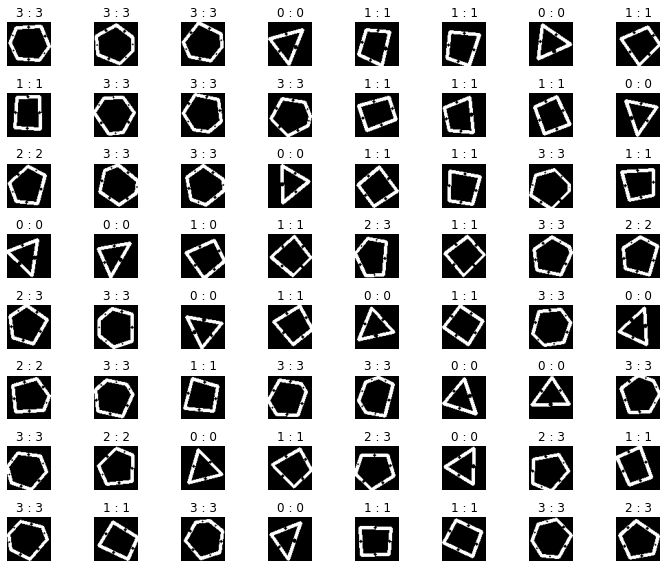

In [8]:
grid_vis(test_loader, 8, model)

In [18]:
# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
# e.g. targets = [ClassifierOutputTarget(281)] # cat 281-287
# e.g. targets = [ClassifierOutputTarget(151)] # dog 151-268
targets = [ClassifierOutputTarget(1)]
# targets = None

In [188]:
target_layers = [model.stages[0][0], model.norm_layers[0]]
print(target_layers)

[Block(
  (dwconv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
  (norm): BatchNorm2d(8, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
  (pwconv1): Linear(in_features=8, out_features=16, bias=True)
  (act): ReLU()
  (pwconv2): Linear(in_features=16, out_features=8, bias=True)
), BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


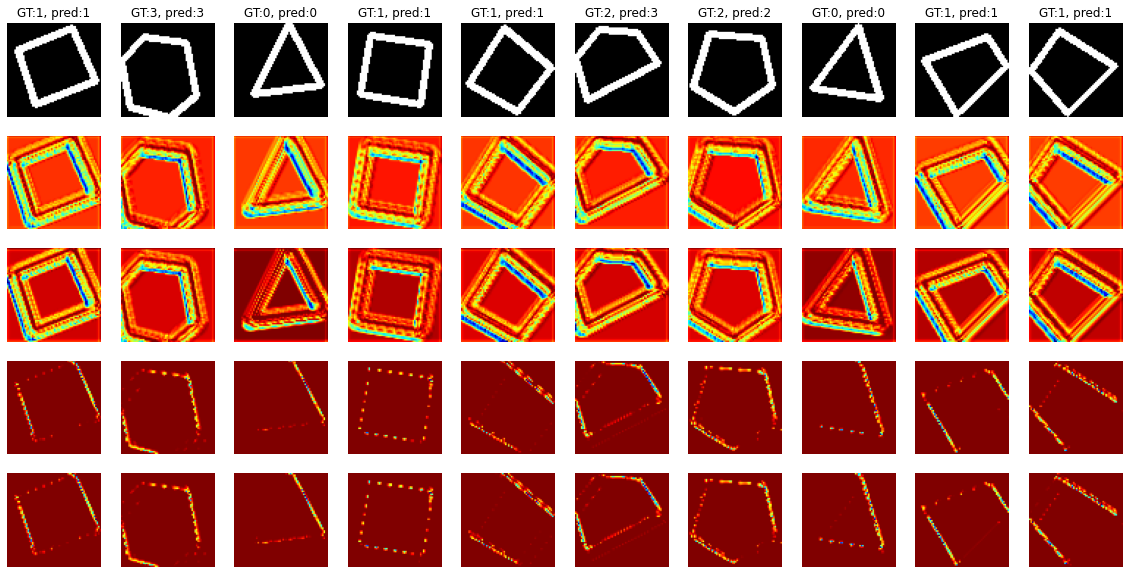

In [49]:
Vis_cam(test_loader, model, target_layers=[model.stages[0][0]], img_num=10)

In [15]:
Vis_cam(test_loader, model, target_layers=[model.stages[1][1]], img_num=10)

IndexError: index 1 is out of range

An exception occurred in CAM with block: <class 'IndexError'>. Message: too many indices for tensor of dimension 0


UnboundLocalError: local variable 'img_cam' referenced before assignment

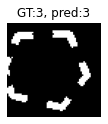

In [26]:
Vis_cam(test_loader, model, target_layers=[model.stages[-1]], img_num=8, mode="heatmap_only")

An exception occurred in CAM with block: <class 'IndexError'>. Message: too many indices for tensor of dimension 0


UnboundLocalError: local variable 'img_cam' referenced before assignment

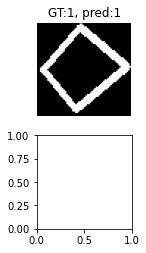

In [14]:
Vis_cam(test_loader, model, target_layers=[model.stages[2][0]], img_num=8, mode="cam_on_img")

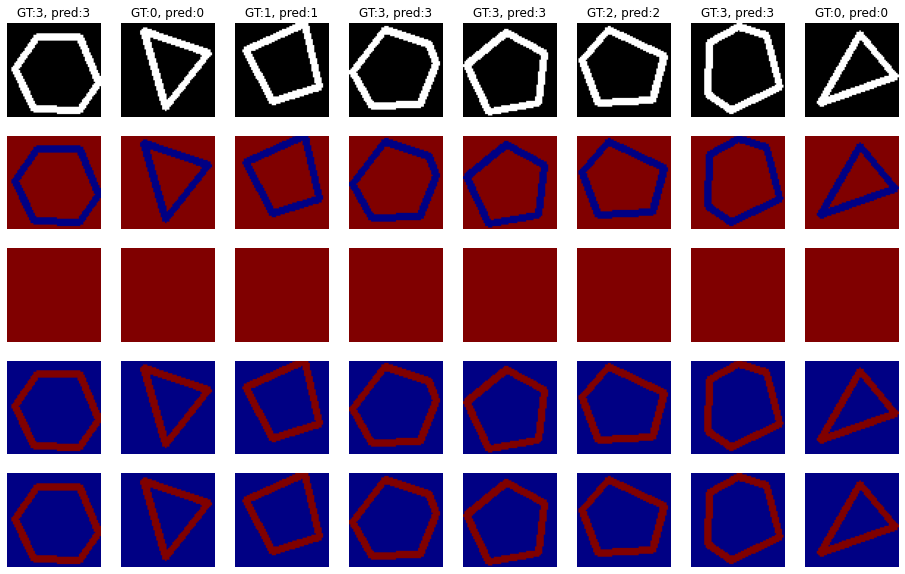

In [25]:
Vis_cam(test_loader, model, target_layers=[model.norm_layers[0]])

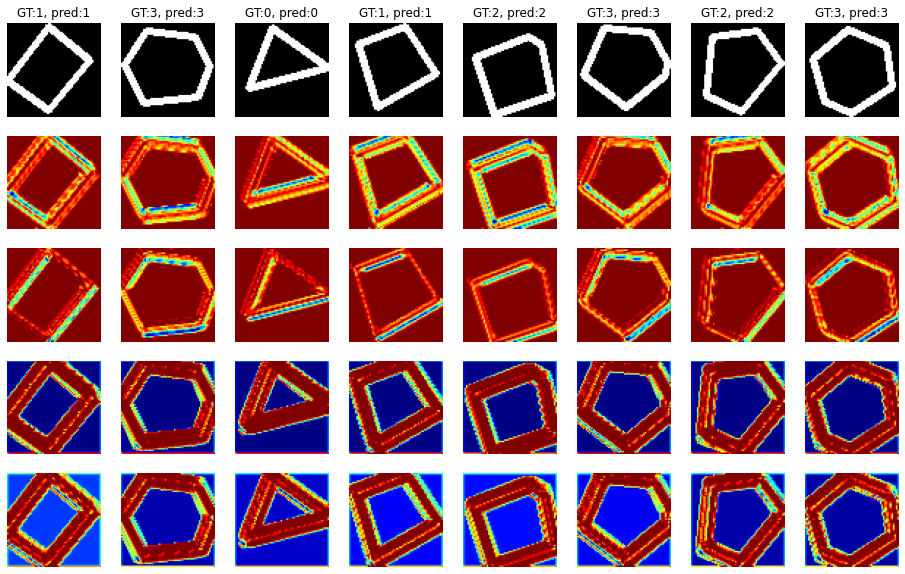

In [23]:
Vis_cam(test_loader, model, target_layers=[model.norm_layers[1]])

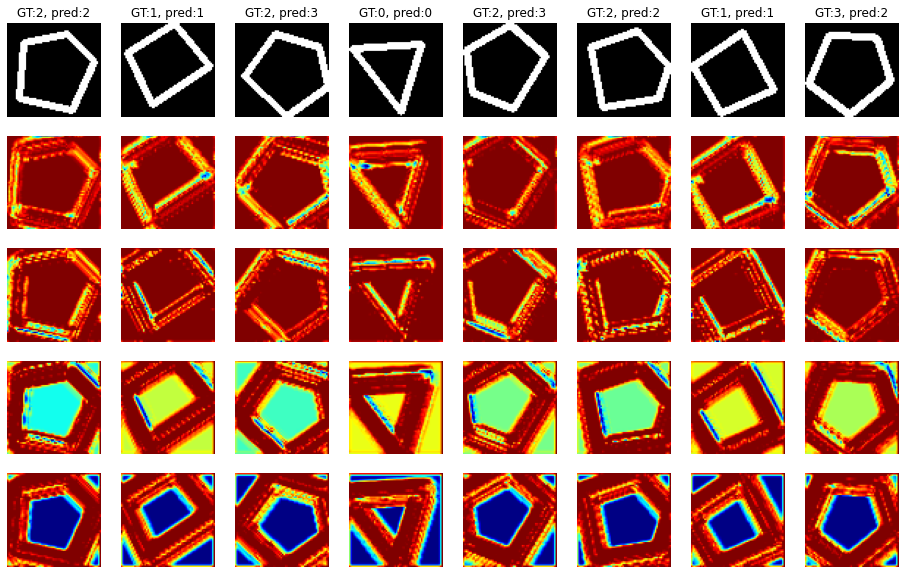

In [24]:
Vis_cam(test_loader, model, target_layers=[model.norm_layers[2]])